# 决策树

---

## ID3

In [4]:
import numpy as np
import pandas as pd
from math import log


In [5]:
df = pd.read_csv('ML04_data.csv')
df

,humility,outlook,play,temp,windy
0,high,sunny,no,hot,False
1,high,sunny,no,hot,True
2,high,overcast,yes,hot,False
3,high,rainy,yes,mild,False
4,normal,rainy,yes,cool,False
5,normal,rainy,no,cool,True
6,normal,overcast,yes,cool,True
7,high,sunny,no,mild,False
8,normal,sunny,yes,cool,False
9,normal,rainy,yes,mild,False


### 计算熵

In [2]:
def entropy(ele):
    probs = [ele.count(i) / len(ele) for i in set(ele)]
    entropy = -sum([prob * log(prob, 2) for prob in probs])
    return entropy

In [4]:
entropy(df['play'].tolist())

0.9402859586706309

### 根据特征和特征值进行数据划分

In [3]:
def split_dataframe(data, col):
    unique_values = data[col].unique();
    result_dict = {elem : pd.DataFrame for elem in unique_values}
    for key in result_dict.keys():
        result_dict[key] = data[:][data[col] == key]
    return result_dict

In [9]:
split_example = split_dataframe(df, 'temp')
split_example

{'hot':    humility   outlook play temp  windy
 0      high     sunny   no  hot  False
 1      high     sunny   no  hot   True
 2      high  overcast  yes  hot  False
 12   normal  overcast  yes  hot  False,
 'mild':    humility   outlook play  temp  windy
 3      high     rainy  yes  mild  False
 7      high     sunny   no  mild  False
 9    normal     rainy  yes  mild  False
 10   normal     sunny  yes  mild   True
 11     high  overcast  yes  mild   True
 13     high     rainy   no  mild   True,
 'cool':   humility   outlook play  temp  windy
 4   normal     rainy  yes  cool  False
 5   normal     rainy   no  cool   True
 6   normal  overcast  yes  cool   True
 8   normal     sunny  yes  cool  False}

In [17]:
df.columns

Index(['humility', 'outlook', 'play', 'temp', 'windy'], dtype='object')

In [10]:
for item, value in split_example.items():
    print(item, value)

hot    humility   outlook play temp  windy
0      high     sunny   no  hot  False
1      high     sunny   no  hot   True
2      high  overcast  yes  hot  False
12   normal  overcast  yes  hot  False
mild    humility   outlook play  temp  windy
3      high     rainy  yes  mild  False
7      high     sunny   no  mild  False
9    normal     rainy  yes  mild  False
10   normal     sunny  yes  mild   True
11     high  overcast  yes  mild   True
13     high     rainy   no  mild   True
cool   humility   outlook play  temp  windy
4   normal     rainy  yes  cool  False
5   normal     rainy   no  cool   True
6   normal  overcast  yes  cool   True
8   normal     sunny  yes  cool  False


### 计算信息增益并选择最佳特征

In [4]:
def choose_best_col(df, label):
    # 信息熵
    entropy_D = entropy(df[label].tolist())
    cols = [col for col in df.columns if col not in [label]]
    max_value, best_col = -999, None
    max_splited = None
    
    for col in cols:
        # 按照特定条件 Y 封装数据 
        splited_set = split_dataframe(df, col)
        # 定义条件熵  H(X | Y)
        entropy_DA = 0
        for subset_col, subset in splited_set.items():
            # 算出每一个条件Y的信息熵
            entropy_Di = entropy(subset[label].tolist())
            # H(X | Y) = P(c) * E(c) 计算每一个事件Y的信息熵
            # 当前事件Y每一个种类的概率P * 当前种类下熵
            entropy_DA += len(subset) / len(df) * entropy_Di
        # 信息增益 = 信息熵 - 条件熵
        info_gain = entropy_D - entropy_DA
        if info_gain > max_value:
            max_value, best_col = info_gain, col
            max_splited = splited_set
    return max_value, best_col, max_splited

In [16]:
choose_best_col(df, 'play')

(0.2467498197744391,
 'outlook',
 {'sunny':    humility outlook play  temp  windy
  0      high   sunny   no   hot  False
  1      high   sunny   no   hot   True
  7      high   sunny   no  mild  False
  8    normal   sunny  yes  cool  False
  10   normal   sunny  yes  mild   True,
  'overcast':    humility   outlook play  temp  windy
  2      high  overcast  yes   hot  False
  6    normal  overcast  yes  cool   True
  11     high  overcast  yes  mild   True
  12   normal  overcast  yes   hot  False,
  'rainy':    humility outlook play  temp  windy
  3      high   rainy  yes  mild  False
  4    normal   rainy  yes  cool  False
  5    normal   rainy   no  cool   True
  9    normal   rainy  yes  mild  False
  13     high   rainy   no  mild   True})

---
## 类式实现

In [14]:
class ID3Tree:
    class Node:
        def __init__(self, name):
            self.name = name
            self.connections = {}

        def connect(self, label, node):
            self.connections[label] = node
            
    def __init__(self, data, label):
        self.columns = data.columns
        self.data = data
        self.label = label
        self.root = self.Node("Root")
        
    def print_tree(self, node, tabs):
        print(tabs + node.name)
        for connection, child_node in node.connections.items():
            # connection是节点里面的值，其中windy属性是bool值，直接相加会报错
            print(tabs + "\t" + "(" + str(connection) + ")")
            self.print_tree(child_node, tabs + "\t\t")

    def construct_tree(self):
        self.construct(self.root, "", self.data, self.columns)
        
    def construct(self, parent_node, parent_connection_label, input_data, columns):
        max_value, best_col, max_splited = choose_best_col(input_data[columns], self.label)
        
        if not best_col:
            node = self.Node(input_data[self.label].iloc[0])
            parent_node.connect(parent_connection_label, node)
            return

        node = self.Node(best_col)
        parent_node.connect(parent_connection_label, node)
        
        new_columns = [col for col in columns if col != best_col]
        
        for splited_value, splited_data in max_splited.items():
            self.construct(node, splited_value, splited_data, new_columns)

In [15]:
tree1 = ID3Tree(df, 'play')
tree1.construct_tree()

In [16]:
tree1.print_tree(tree1.root, "")

Root
	()
		outlook
			(sunny)
				humility
					(high)
						temp
							(hot)
								windy
									(False)
										no
									(True)
										no
							(mild)
								windy
									(False)
										no
					(normal)
						temp
							(cool)
								windy
									(False)
										yes
							(mild)
								windy
									(True)
										yes
			(overcast)
				humility
					(high)
						temp
							(hot)
								windy
									(False)
										yes
							(mild)
								windy
									(True)
										yes
					(normal)
						temp
							(cool)
								windy
									(True)
										yes
							(hot)
								windy
									(False)
										yes
			(rainy)
				windy
					(False)
						humility
							(high)
								temp
									(mild)
										yes
							(normal)
								temp
									(cool)
										yes
									(mild)
										yes
					(True)
						humility
							(normal)
								temp
									(cool)
										no
							(high)
								temp
									(mild)
										no


---

## Sklearn

In [2]:
import graphviz

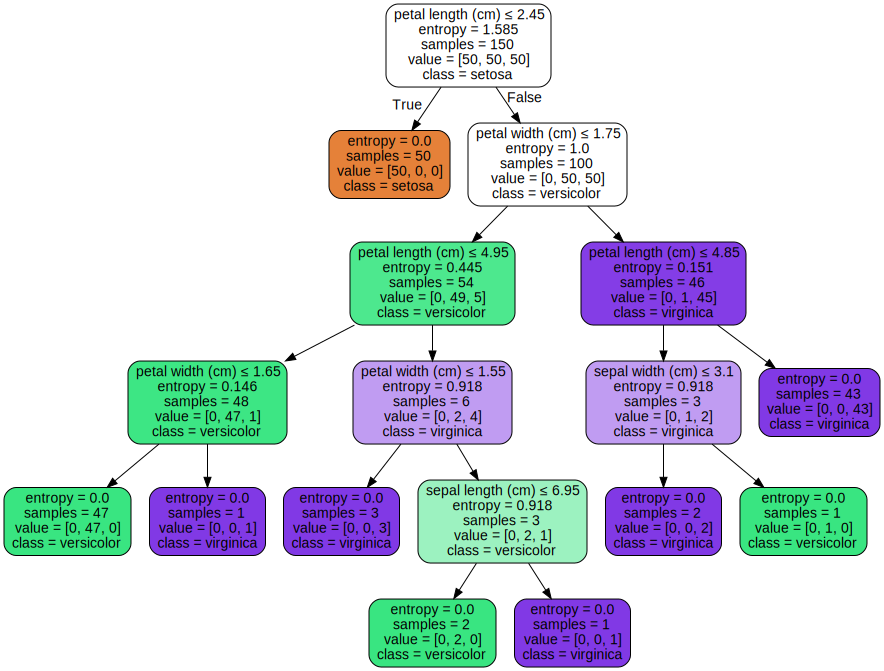

In [3]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
# criterion选择entropy，这里表示选择ID3算法
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf = clf.fit(iris.data, iris.target)

dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names=iris.feature_names,
                               class_names=iris.target_names,
                               filled=True, 
                               rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph